In [60]:
params_resource_dir = "../resources/"
params_subset_cell_lines = ["HepG2", "K562"]
params_subset_chroms = [
    "chr8",
]


# Datasets - RNA structures

## Overview

## Imports

In [ ]:
import os
import sys
from abc import ABC
from dataclasses import dataclass
from pathlib import Path
from typing import Literal

import forgi.graph.bulge_graph as fgb
import forgi.visual.mplotlib as fvm
import numpy as np
import pandas as pd
import pyBigWig as pbw
import pyfaidx
import RNA
from dotmap import DotMap
from snakemake.io import glob_wildcards

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Definitions

In [ ]:
@dataclass
class GenomicInterval:
    chrom: str
    start: int
    end: int
    name: str
    score: int | float | str
    strand: Literal["+", "-"]

    def __post_init__(self):
        # Enforce [0, end) interval.
        if self.start < 0:
            raise ValueError(f"Start position {self.start} must be non-negative.")
        if self.start >= self.end:
            raise ValueError(f"Start position {self.start} must be less than end position {self.end}.")


In [32]:
class FoldingParams(ABC):
    pass


@dataclass
class DeiganFoldingParams(FoldingParams):
    m: float = 1.4
    b: float = -0.8


@dataclass
class FoldedRNA:
    sequence: str
    dotbracket: str
    mfe: float
    folding_params: FoldingParams


def mfe_guided_fold(sequence: str, reactivities: np.ndarray, folding_params: FoldingParams) -> FoldedRNA:
    fc = RNA.fold_compound(sequence)

    if not isinstance(folding_params, DeiganFoldingParams):
        raise ValueError("Only DeiganFoldingParams is supported.")

    # Add SHAPE reactivity data using the Deigan et al. method
    fc.sc_add_SHAPE_deigan(reactivities, m=folding_params.m, b=folding_params.b)

    # Compute the minimum free energy (MFE) structure
    mfe_structure, mfe = fc.mfe()

    return FoldedRNA(
        sequence=sequence,
        dotbracket=mfe_structure,
        mfe=mfe,
        folding_params=folding_params,
    )


from collections.abc import Sequence


def hamming_distance(s1: Sequence, s2: Sequence):
    if not len(s1) == len(s2):
        raise ValueError("Different lengths of sequences.")
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))


from typing import Any


def tryint(s: str) -> Any:
    try:
        return int(s)
    except:
        return s

In [110]:
# TODO: this function is only for visualization, lots of things hardcoded...


def plot_structure(sequence: str, reactivities: list[float], ax):
    deigan_params = DeiganFoldingParams()
    mfe_data: FoldedRNA = mfe_guided_fold(sequence=sequence, reactivities=reactivities, folding_params=deigan_params)

    dot_bracket = mfe_data.dotbracket
    norm_reactivities = np.clip(reactivities, 0, 1)  # Clip outliers to max 1
    colors = plt.cm.viridis(norm_reactivities)  # Use a colormap

    # Create a BulgeGraph object from dot-bracket notation
    bg = fgb.BulgeGraph.from_dotbracket(dot_bracket, sequence)

    # Assign colors to nucleotides in the graph
    node_colors = {str(i + 1): colors[i] for i in range(len(sequence))}  # 1-based indexing

    # Create figure and plot RNA with node colors
    fvm.plot_rna(bg, ax=ax, lighten=0.5)  # Use node_colors instead of color_list

    # Add a colorbar
    # sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
    # plt.colorbar(sm, ax=ax, label="DMS Reactivity")

    return ax

## Initialize

In [61]:
resource_dir = Path(params_resource_dir)
if not resource_dir.exists():
    raise FileNotFoundError("Resource directory does not exist: " + str(resource_dir))

print("Using resources from:", resource_dir)

Using resources from: ../resources


## Load data

### Genome data and annotations

TODO: to be used to give an overview of missing values (% missing genes per gene type, % missing per biotype, etc.)

In [63]:
# We also load the genome FASTA file, to demonstrate basic sequence enrichment analysis.
fa = pyfaidx.Fasta(resource_dir / "general" / "genome" / "hg38.fa.gz")

### RNA-structure probing data

In [18]:
probing_data = DotMap()

In [30]:
ufmt_input_filepath_bw = "../resources/sun_et_al_2021_icshape_data/{CELL_LINE}.{STRAND}.bw"

globbed_wildcards = glob_wildcards(ufmt_input_filepath_bw)

if len(set(params_subset_cell_lines) & set(globbed_wildcards.CELL_LINE)) > 0:
    subset_cell_lines = list(set(params_subset_cell_lines) & set(globbed_wildcards.CELL_LINE))
else:
    subset_cell_lines = list(set(globbed_wildcards.CELL_LINE))

table_wildcards = pd.DataFrame(globbed_wildcards._asdict())
display(table_wildcards.head(5))

for _, row in table_wildcards.loc[lambda df: df["CELL_LINE"].isin(subset_cell_lines), :].iterrows():
    print(f"Loading probing data for cell line {row.CELL_LINE} and strand {row.STRAND}")
    probing_data[row.CELL_LINE][row.STRAND] = pbw.open(
        ufmt_input_filepath_bw.format(CELL_LINE=row.CELL_LINE, STRAND=row.STRAND)
    )

,CELL_LINE,STRAND
0,K562,minus
1,H9,minus
2,HepG2,plus
3,K562,plus
4,HEK293T,minus


Loading probing data for cell line K562 and strand minus
Loading probing data for cell line HepG2 and strand plus
Loading probing data for cell line K562 and strand plus
Loading probing data for cell line HepG2 and strand minus


## Demo - RNA structure - single example

### Retrieve probing data

In [58]:
# We will work with a random genomic annotation for now.
# NOTE: GAPDH is selected because highly expressed in HepG2 cell lines.
example_interval = GenomicInterval(
    chrom="chr12",
    start=6_538_170,
    end=6_538_371,
    name="three_prime_UTR;GAPDH;ENST00000229239.10",
    score=".",
    strand="+",
)

In [54]:
example_interval.end - example_interval.start

201

In [86]:
reactivities = probing_data["HepG2"]["plus"].values(
    example_interval.chrom,
    example_interval.start,
    example_interval.end,
)

print(f"{len(reactivities)=:_}")
print(f"{list(reactivities[:10])=}")

len(reactivities)=201
list(reactivities[:10])=[1.0, 0.3779999911785126, 0.4909999966621399, 0.10700000077486038, 0.2160000056028366, 0.33000001311302185, 0.5289999842643738, 0.2540000081062317, 0.37299999594688416, 0.5580000281333923]


### Fold a sequence

In [87]:
sequence = str(fa[example_interval.chrom][example_interval.start : example_interval.end])
print(f"{len(sequence)=:_}")
print(f"{list(sequence[:10])=}")

len(sequence)=201
list(sequence[:10])=['G', 'A', 'C', 'C', 'C', 'C', 'T', 'G', 'G', 'A']


In [71]:
deigan_params = DeiganFoldingParams()
print(deigan_params)

DeiganFoldingParams(m=1.4, b=-0.8)


In [ ]:
mfe_data: FoldedRNA = mfe_guided_fold(sequence=sequence, reactivities=list(reactivities), folding_params=deigan_params)

print(mfe_data.dotbracket)

((...((((....))))((((((((.........((((...........))))..))))))))..((((((((....(((((..........))))).(((((((((.(((..(((........)))....))).))))))))))))..)))))...(((...)))(((((((..........))))...))).)).....


| Letter | Structure Type         | Case      | Meaning                         |
|--------|------------------------|-----------|---------------------------------|
| H/h    | Helix                  | Uppercase | Paired in helix                 |
| H/h    | Helix                  | Lowercase | Unpaired in helix region        |
| I/i    | Internal loop          | Uppercase | Paired in internal loop         |
| I/i    | Internal loop          | Lowercase | Unpaired in internal loop       |
| M/m    | Multiloop              | Uppercase | Paired in multiloop             |
| M/m    | Multiloop              | Lowercase | Unpaired in multiloop           |
| B/b    | Bulge                  | Uppercase | Paired in bulge                 |
| B/b    | Bulge                  | Lowercase | Unpaired in bulge               |
| E/e    | External loop          | Any       | Unpaired (external)             |
| S/s    | Single-stranded region | Any       | Unpaired (usually terminal)     |

In [ ]:
print("sequence".ljust(20), mfe_data.sequence[:20], "...")
print("dotbracket".ljust(20), mfe_data.dotbracket[:20], "...")
print("paired/unpaired".ljust(20), "".join(map({"(": "1", ")": "1", ".": "0"}.get, mfe_data.dotbracket))[:20], "...")
print("HIMS alphabet".ljust(20), RNA.db_to_element_string(mfe_data.dotbracket)[:20], "...")

sequence             GACCCCTGGACCACCAGCCC ...
dotbracket           ((...((((....))))((( ...
paired/unpaired      11000111100001111111 ...
HIMS alphabet        IMmmmIIIHhhhhHIIIIII ...


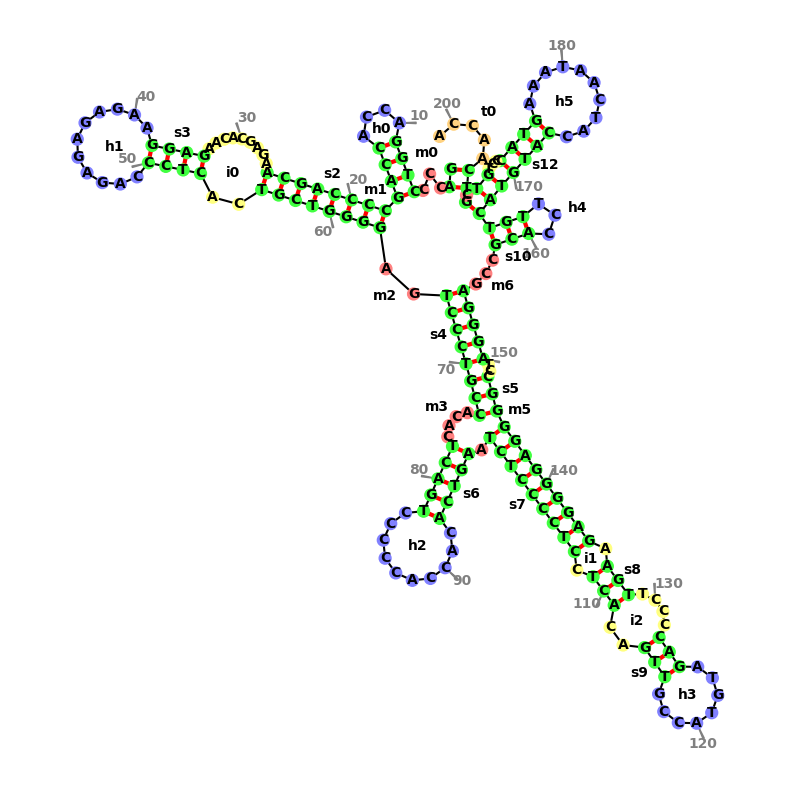

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)
plot_structure(
    sequence=mfe_data.sequence,
    reactivities=list(reactivities),
    ax=ax1,
)
plt.show()